In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
import pickle

extract_location = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/extracted.pkl'

with open(extract_location, 'rb') as f:
    extracted = pickle.load(f)

## data preprocessing

In [44]:
from sklearn.model_selection import train_test_split

sessions = []
for session in extracted:
        current = session['notes']['currentLevel']
        data = np.mean(session['data']/current, axis = 2)
        data = data[:, 330:420]
        temp = {
            'data': data, 
            'label': 0 if session['notes']['phenoCode'] == 1.0 else 1, 
            'stim': session['notes']['sessionType']}
        sessions.append(temp)

# for idx, session in enumerate(sessions):
#     data = session['data']
#     label = session['label']
#     if data.shape[0] != 2 or data.shape[1] != 700:
#         sessions.pop(idx)
#         print(f"Removed Session {idx} data shape: {np.shape(data)}, label: {label}")


sessions = [session for session in sessions if session['stim'] == 'sciatic']

X = np.stack([session['data'] for session in sessions], axis = 0)
y = np.array([session['label'] for session in sessions])

X.shape

(47, 2, 90)

## PCA Visualisation

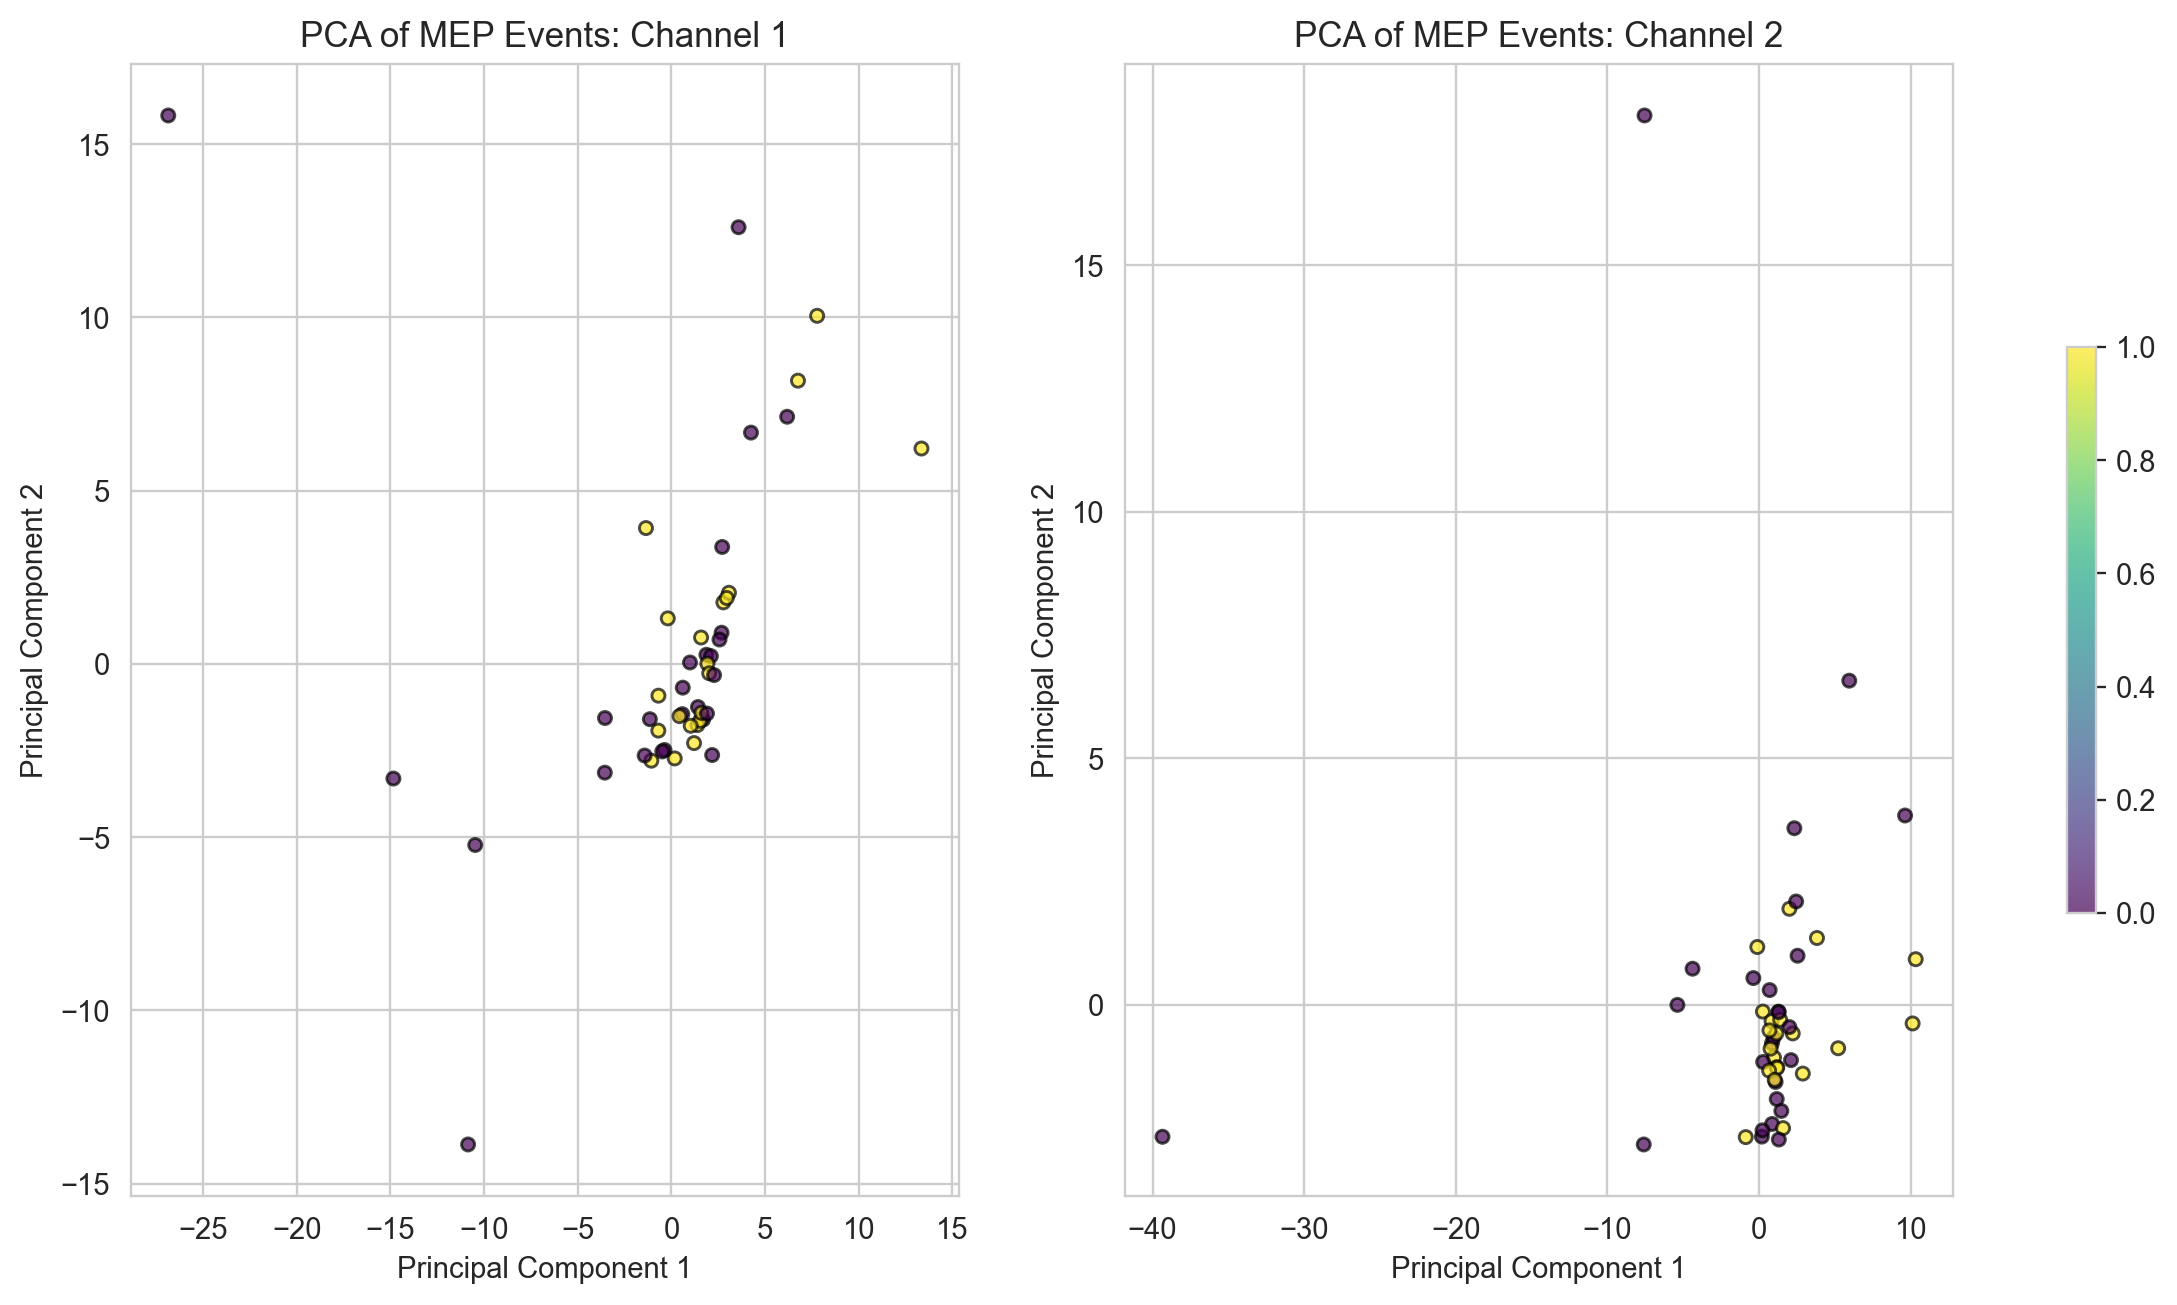

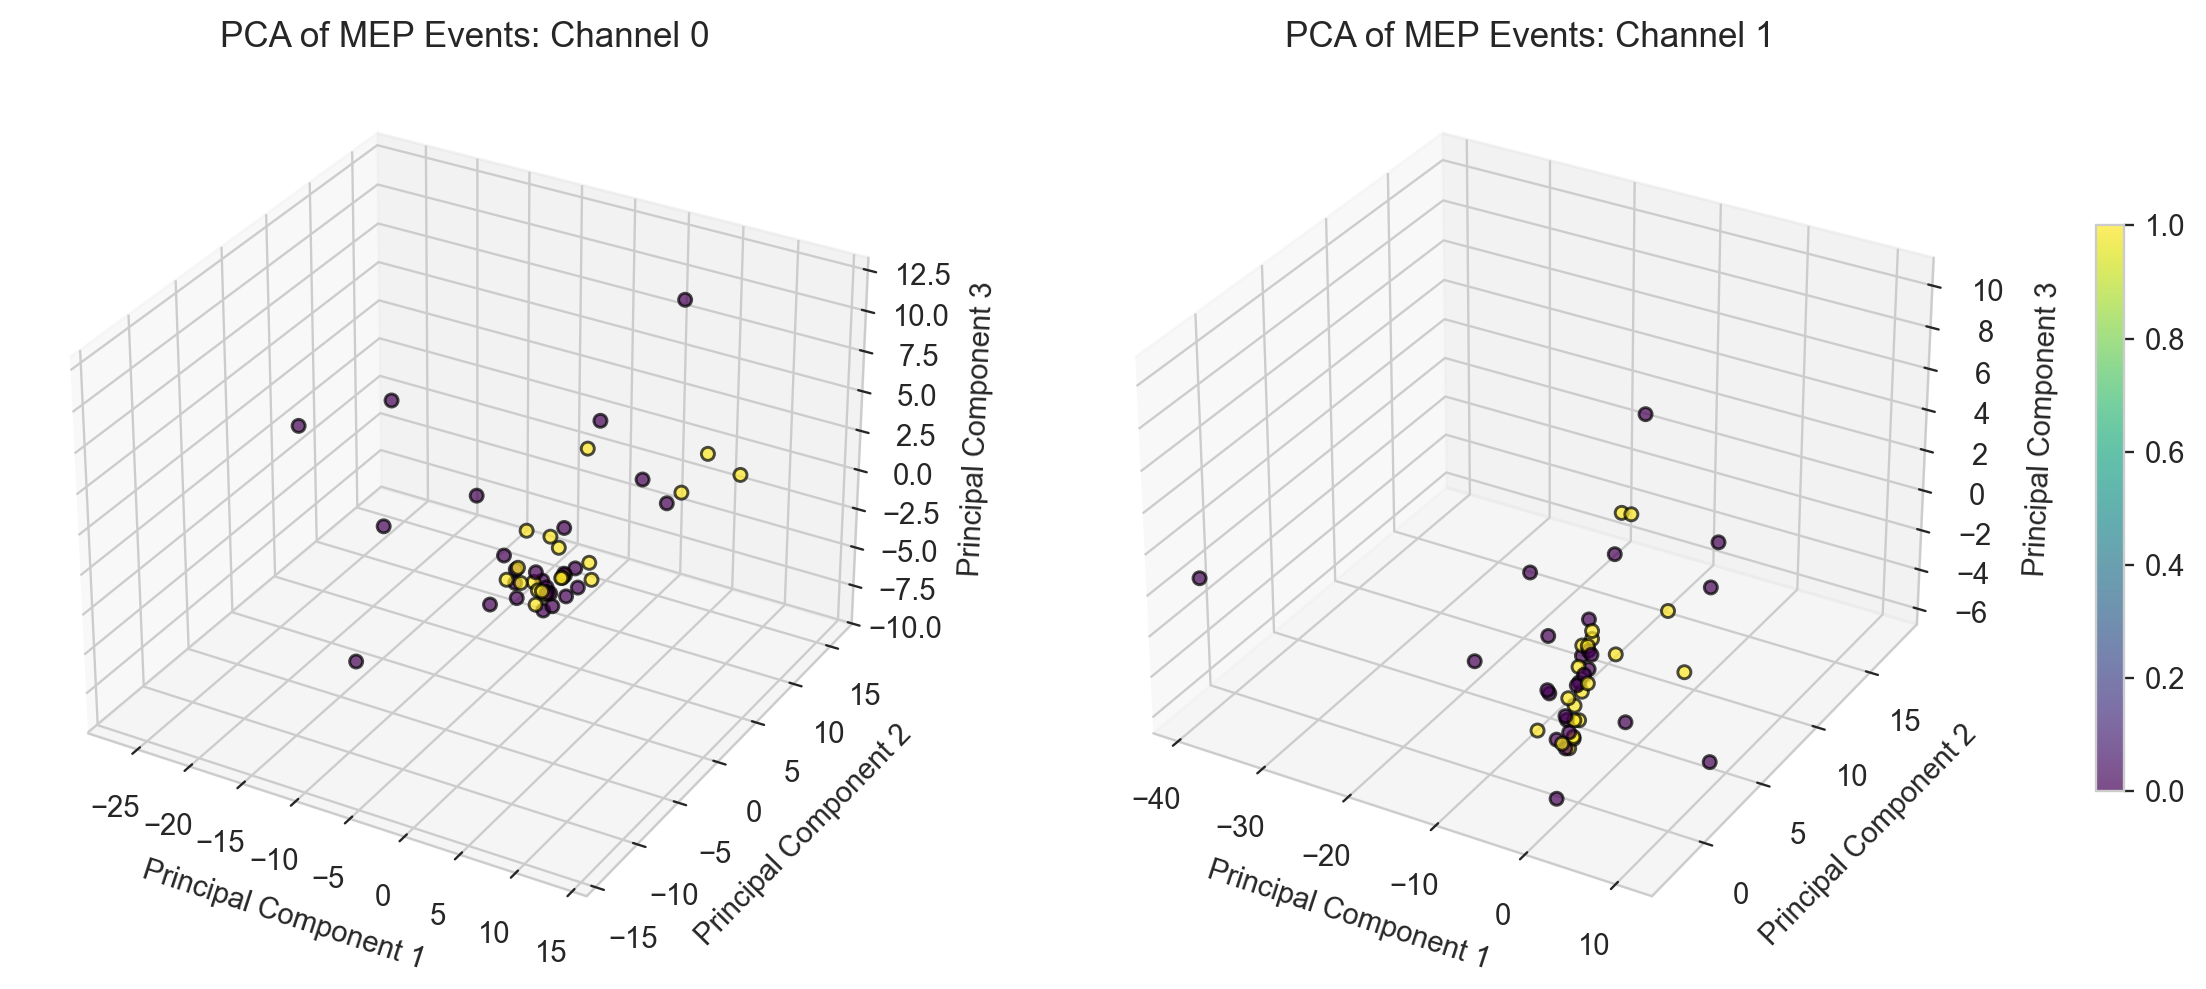

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def extract_features(X, y, n_components):
    
    try:
        n_components in [2, 3]
    except:
        print("n_components must be 2 or 3")
        return
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=343
    )

    # Prepare arrays for scaled data
    X_train_scaled = np.empty_like(X_train)
    X_test_scaled = np.empty_like(X_test)

    n_channels = X_train.shape[1]

    # Create a figure with one 3-D subplot per channel\
    if n_components == 2:
        fig, axes = plt.subplots(1, n_channels, figsize=(14, 7), dpi=210)
    else:
        fig = plt.figure(figsize=(15, 7), dpi=210)
        axes = []
        for channel in range(n_channels):
            ax = fig.add_subplot(1, n_channels, channel+1, projection='3d')
            axes.append(ax)
    

    # Loop over each channel
    for channel in range(n_channels):
        scaler = StandardScaler()
        # Scale the training and testing data per channel
        X_train_scaled[:, channel, :] = scaler.fit_transform(X_train[:, channel, :])
        X_test_scaled[:, channel, :] = scaler.transform(X_test[:, channel, :])
        
        if n_components == 2:
            # use PCA to reduce the dimensions to 2 for visualization
            pca_plot = PCA(n_components=2, random_state=343)
            X_train_pca_plot = pca_plot.fit_transform(X_train_scaled[:, channel, :])
            X_test_pca_plot = pca_plot.transform(X_test_scaled[:, channel, :])
    
            ax = axes[channel]
            # plot training data
            scatter_train = ax.scatter(X_train_pca_plot[:, 0], X_train_pca_plot[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=20, alpha = 0.7)
            scatter_test = ax.scatter(X_test_pca_plot[:, 0], X_test_pca_plot[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=20, alpha = 0.7)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_title(f'PCA of MEP Events: Channel {channel + 1}')
            ax.grid(True)
            
        else:
            # use PCA to reduce the dimensions to 3 for visualization
            pca_plot = PCA(n_components=3, random_state=343)
            X_train_pca_plot = pca_plot.fit_transform(X_train_scaled[:, channel, :])
            X_test_pca_plot = pca_plot.transform(X_test_scaled[:, channel, :])
    
            ax = axes[channel]
            # Plot training data
            scatter_train = ax.scatter(
                X_train_pca_plot[:, 0],
                X_train_pca_plot[:, 1],
                X_train_pca_plot[:, 2],
                c=y_train,
                cmap='viridis',
                edgecolor='k',
                s=20,
                alpha=0.7,
                label='Train'
            )
            # Plot testing data
            scatter_test = ax.scatter(
                X_test_pca_plot[:, 0],
                X_test_pca_plot[:, 1],
                X_test_pca_plot[:, 2],
                c=y_test,
                cmap='viridis',
                edgecolor='k',
                s=20,
                alpha=0.7,
                label='Test'
            )
    
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            ax.set_title(f'PCA of MEP Events: Channel {channel}')
            ax.grid(True)

    # Optionally, add a colorbar to one of the axes
    fig.colorbar(scatter_train, ax=axes, shrink=0.5, aspect=20)
    plt.show()

# Example call (ensure X and y are defined appropriately)
extract_features(X, y, n_components=2)
extract_features(X, y, n_components=3)


## ML

In [45]:
import xgboost
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Reshape X to 2D if needed
X_2D = X.reshape(X.shape[0], -1)
print("X Shape:", X_2D.shape)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_2D, y, test_size=0.2, stratify=y, random_state=343
)

# Define the XGBClassifier with GPU acceleration
xgb_pipeline = xgboost.XGBClassifier(
    eval_metric="logloss",
)

# Define correct parameter grid
xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 10, 100]  # L2 regularization
}

# Compute sample weights for class imbalance handling
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Randomized Search with GPU-accelerated training
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    n_iter=20,  # Reduce for faster training (adjust as needed)
    cv=5,
    scoring="precision",
    n_jobs=-1,
    verbose=1,
    random_state=343
)

# Train the best XGBoost model with GPU acceleration & class balancing
xgb_random_search.fit(
    X_train, y_train, sample_weight=sample_weights
)

# Retrieve the best GPU-optimized model
best_xgb = xgb_random_search.best_estimator_

# Print results
print("Best Parameters:", xgb_random_search.best_params_)
print("Best Cross-Validation Precision:", xgb_random_search.best_score_)

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


X Shape: (47, 180)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best Parameters: {'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation Precision: 0.7033333333333334


## deep learning classifier

In [18]:
import torch
import torch.nn as nn

class TimeSeriesClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Input shape: (batch_size, 2, 700)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [25]:
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

# convert numpy arrays to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# create a dataset and split into train/validation sets
full_dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# define a time series augmentation transform
class TimeSeriesAugmentation:
    def __call__(self, x):
        # randomly add noise
        if np.random.rand() > 0.5:
            x = x + torch.randn_like(x) * 0.01
        # randomly perform a time shift
        if np.random.rand() > 0.5:
            shift = np.random.randint(-10, 10)
            x = torch.roll(x, shifts=shift, dims=-1)
        return x

# custom dataset that applies a transformation to the inputs
class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.base_dataset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.base_dataset)

# wrap the training subset with the augmentation
train_dataset = TransformedDataset(train_subset, TimeSeriesAugmentation())

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
train_loader_augmented = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size)


In [26]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = TimeSeriesClassifier().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs (adjust based on your needs)
num_epochs = 50

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * inputs.size(0)

    # validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # calculate epoch statistics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        
print()

Epoch 1/50:
Train Loss: 0.7056 | Val Loss: 0.5351 | Val Acc: 0.6000
Epoch 2/50:
Train Loss: 0.7856 | Val Loss: 0.4878 | Val Acc: 0.6000
Epoch 3/50:
Train Loss: 0.7355 | Val Loss: 0.5057 | Val Acc: 0.6000
Epoch 4/50:
Train Loss: 0.7618 | Val Loss: 0.5713 | Val Acc: 0.6000
Epoch 5/50:
Train Loss: 0.7495 | Val Loss: 0.6991 | Val Acc: 0.3000
Epoch 6/50:
Train Loss: 0.6432 | Val Loss: 0.7379 | Val Acc: 0.3000
Epoch 7/50:
Train Loss: 0.6719 | Val Loss: 0.7762 | Val Acc: 0.4000
Epoch 8/50:
Train Loss: 0.6727 | Val Loss: 0.8374 | Val Acc: 0.3000
Epoch 9/50:
Train Loss: 0.6561 | Val Loss: 0.8740 | Val Acc: 0.3000
Epoch 10/50:
Train Loss: 0.6806 | Val Loss: 0.8332 | Val Acc: 0.3000
Epoch 11/50:
Train Loss: 0.6608 | Val Loss: 0.7930 | Val Acc: 0.4000
Epoch 12/50:
Train Loss: 0.6260 | Val Loss: 0.7612 | Val Acc: 0.4000
Epoch 13/50:
Train Loss: 0.6479 | Val Loss: 0.7539 | Val Acc: 0.4000
Epoch 14/50:
Train Loss: 0.6454 | Val Loss: 0.7764 | Val Acc: 0.4000
Epoch 15/50:
Train Loss: 0.6382 | Val Loss:

In [27]:
# load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print(f"Final Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"F1 Score: {f1_score(all_labels, all_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(all_labels, all_preds):.4f}")

Final Accuracy: 0.6000
F1 Score: 0.0000
ROC AUC: 0.5000
